In [5]:
#the file has all pre-processing and aggregation i have done to match the SCM + jobs study (connected to O'net data)
#i use the same no. and the same type of professions they used
#At the end of the file there is a custom bias direction validates against human filled study rankings (not O'NET) from study above.
#Different soplits were tested as well as the approach starting with pca (I have results for those) but this one provided
#sig. spearman correl after projection to bias dir and comparing to human rankings
import os
import numpy as np
import pandas as pd

In [7]:
file_path = '/Users/aleksandragarbat/Desktop/Thesis/Interests.xlsx'
#jobs rated in 7 point scale (1=the lowest relevance)
df = pd.read_excel(file_path)
df.head()

,O*NET-SOC Code,Title,Element ID,Element Name,Scale ID,Scale Name,Data Value,Date,Domain Source
0,11-1011.00,Chief Executives,1.B.1.a,Realistic,OI,Occupational Interests,1.30,11/2023,Machine Learning
1,11-1011.00,Chief Executives,1.B.1.b,Investigative,OI,Occupational Interests,3.24,11/2023,Machine Learning
2,11-1011.00,Chief Executives,1.B.1.c,Artistic,OI,Occupational Interests,2.08,11/2023,Machine Learning
3,11-1011.00,Chief Executives,1.B.1.d,Social,OI,Occupational Interests,3.52,11/2023,Machine Learning
4,11-1011.00,Chief Executives,1.B.1.e,Enterprising,OI,Occupational Interests,6.88,11/2023,Machine Learning


In [9]:
#selected columns
df_selected = df[['Title', 'Element Name', 'Data Value']]
print(df_selected.head())

              Title   Element Name  Data Value
0  Chief Executives      Realistic        1.30
1  Chief Executives  Investigative        3.24
2  Chief Executives       Artistic        2.08
3  Chief Executives         Social        3.52
4  Chief Executives   Enterprising        6.88


In [11]:
#pivoting data
df_pivot = df_selected.pivot_table(index='Title', columns='Element Name', values='Data Value', aggfunc='first')
df_pivot = df_pivot.reset_index()
df_pivot.columns.name = None
print(df_pivot.head())


                      Title  Artistic  Conventional  Enterprising  \
0  Accountants and Auditors      1.09          7.00          3.86   
1                    Actors      7.00          1.67          4.00   
2                 Actuaries      1.18          6.24          3.41   
3            Acupuncturists      2.12          3.11          1.77   
4         Acute Care Nurses      1.48          3.49          1.62   

   First Interest High-Point  Investigative  Realistic  \
0                        6.0           3.57       1.14   
1                        3.0           2.13       2.31   
2                        6.0           4.44       1.81   
3                        4.0           5.32       4.60   
4                        4.0           5.41       4.04   

   Second Interest High-Point  Social  Third Interest High-Point  
0                         5.0    2.13                        2.0  
1                         4.0    4.10                        5.0  
2                         2.0    2.

In [13]:
#scores for warmth and competence considering correlations from study
#competence score based on correlations from study
df_pivot['Competence'] = (
    0.50 * df_pivot['Investigative'] +
    -0.22 * df_pivot['Realistic'] +
    -0.23 * df_pivot['Conventional']
)

#warmth score score based on correlations from study
df_pivot['Warmth'] = (
    0.31 * df_pivot['Social'] +
    -0.23 * df_pivot['Enterprising'] +
    0.25 * df_pivot['Realistic']
)
print(df_pivot[['Title', 'Competence', 'Warmth']].head())



                      Title  Competence  Warmth
0  Accountants and Auditors     -0.0758  0.0575
1                    Actors      0.1727  0.9285
2                 Actuaries      0.3866  0.4339
3            Acupuncturists      0.9327  2.5099
4         Acute Care Nurses      1.0135  2.4571


In [17]:
#sample
df_30_records = df_pivot[['Title', 'Competence', 'Warmth']].head(30)
print(df_30_records)

                                                Title  Competence  Warmth
0                            Accountants and Auditors     -0.0758  0.0575
1                                              Actors      0.1727  0.9285
2                                           Actuaries      0.3866  0.4339
3                                      Acupuncturists      0.9327  2.5099
4                                   Acute Care Nurses      1.0135  2.4571
5              Adapted Physical Education Specialists      0.0251  2.8483
6      Adhesive Bonding Machine Operators and Tenders     -1.4313  1.6874
7   Administrative Law Judges, Adjudicators, and H...      0.5365 -0.0028
8                    Administrative Services Managers     -0.8137  0.0503
9   Adult Basic Education, Adult Secondary Educati...      0.2251  2.1061
10               Advanced Practice Psychiatric Nurses      1.4740  2.0900
11                           Advertising Sales Agents     -0.5861 -0.3824
12                Advertising and Prom

In [19]:
#reduce the halo effect with residuals to ensure independent analysis
import statsmodels.api as sm

#regressed competence on warmth to get the residuals for competence
X = sm.add_constant(df_pivot['Warmth'])
y_competence = df_pivot['Competence']
model_competence = sm.OLS(y_competence, X).fit()
df_pivot['Competence_residual'] = model_competence.resid

#regressed warmth on competence to get the residuals for warmth
X = sm.add_constant(df_pivot['Competence'])
y_warmth = df_pivot['Warmth']
model_warmth = sm.OLS(y_warmth, X).fit()
df_pivot['Warmth_residual'] = model_warmth.resid

                      Title  Competence  Competence_residual  Warmth  \
0  Accountants and Auditors     -0.0758             0.319752  0.0575   
1                    Actors      0.1727             0.549647  0.9285   
2                 Actuaries      0.3866             0.774112  0.4339   
3            Acupuncturists      0.9327             1.275869  2.5099   
4         Acute Care Nurses      1.0135             1.357797  2.4571   

   Warmth_residual  
0        -1.352473  
1        -0.484053  
2        -0.980874  
3         1.089456  
4         1.035817  


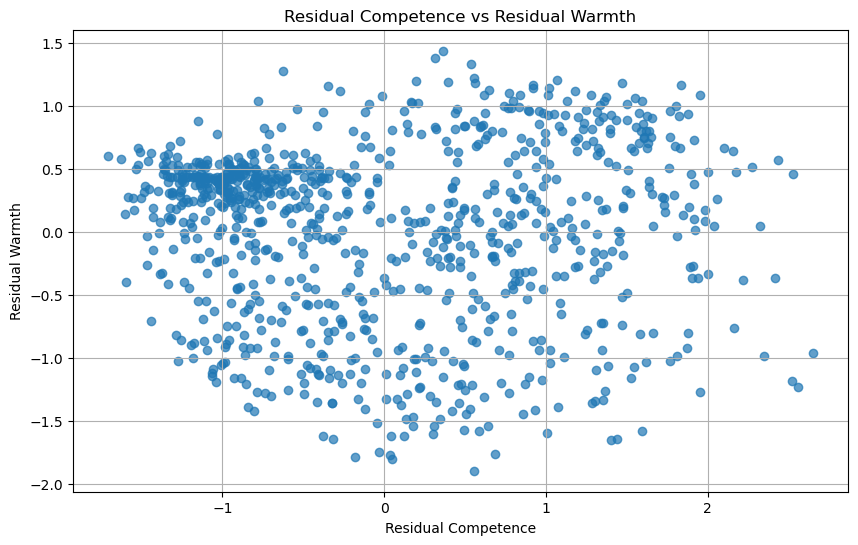

In [21]:
#first few rows to check the residuals
print(df_pivot[['Title', 'Competence', 'Competence_residual', 'Warmth', 'Warmth_residual']].head())

import matplotlib.pyplot as plt

# residuals for competence vs. warmth they are non-correlated
plt.figure(figsize=(10, 6))
plt.scatter(df_pivot['Competence_residual'], df_pivot['Warmth_residual'], alpha=0.7)
plt.xlabel('Residual Competence')
plt.ylabel('Residual Warmth')
plt.title('Residual Competence vs Residual Warmth')
plt.grid(True)
plt.show()

In [23]:
#sorting
df_sorted = df_pivot.sort_values(by=['Warmth_residual', 'Competence_residual'], ascending=[False, False])

#checking
print(df_sorted[['Title', 'Warmth_residual', 'Competence_residual']].head())

#title col to lowercase
df_pivot['Title'] = df_pivot['Title'].str.lower()
df_pivot

                                                 Title  Warmth_residual  \
5               Adapted Physical Education Specialists         1.437279   
669                      Physical Therapist Assistants         1.381106   
275                      Emergency Medical Technicians         1.328390   
29   Ambulance Drivers and Attendants, Except Emerg...         1.275353   
54                                   Athletic Trainers         1.216933   

     Competence_residual  
5               0.361041  
669             0.311552  
275             0.535628  
29             -0.624681  
54              0.553206  


,Title,Artistic,Conventional,Enterprising,First Interest High-Point,Investigative,Realistic,Second Interest High-Point,Social,Third Interest High-Point,Competence,Warmth,Competence_residual,Warmth_residual
0,accountants and auditors,1.09,7.00,3.86,6.0,3.57,1.14,5.0,2.13,2.0,-0.0758,0.0575,0.319752,-1.352473
1,actors,7.00,1.67,4.00,3.0,2.13,2.31,4.0,4.10,5.0,0.1727,0.9285,0.549647,-0.484053
2,actuaries,1.18,6.24,3.41,6.0,4.44,1.81,2.0,2.47,5.0,0.3866,0.4339,0.774112,-0.980874
3,acupuncturists,2.12,3.11,1.77,4.0,5.32,4.60,2.0,5.70,1.0,0.9327,2.5099,1.275869,1.089456
4,acute care nurses,1.48,3.49,1.62,4.0,5.41,4.04,2.0,5.87,1.0,1.0135,2.4571,1.357797,1.035817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,wind turbine service technicians,1.00,4.30,1.78,1.0,3.57,7.00,6.0,1.61,2.0,-0.7440,1.8397,-0.386516,0.436665
919,"woodworking machine setters, operators, and te...",1.15,4.15,1.03,1.0,2.43,7.00,6.0,1.18,0.0,-1.2795,1.8789,-0.922853,0.481425
920,word processors and typists,2.22,6.60,1.92,6.0,1.93,2.87,0.0,2.27,0.0,-1.1844,0.9796,-0.808544,-0.418862
921,writers and authors,6.93,3.18,4.80,3.0,3.26,1.00,5.0,2.84,0.0,0.6786,0.0264,1.074816,-1.391406


In [874]:
#### DOCTORS
doctor_titles = [
    'physicians', 'surgeons', 'pediatricians', 'obstetricians', 
    'orthopedic surgeons', 'anesthesiologists', 'epidemiologists',
    'oral and maxillofacial surgeons', 'radiologists', 
    'dermatologists', 'cardiologists'
]

#filtering
doctor_df = df_pivot[df_pivot['Title'].apply(lambda x: any(doctor_title in x.lower() for doctor_title in doctor_titles))]

#grouped_title' to group doctor-related titles as doctor
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Doctor' if any(doctor_title in x.lower() for doctor_title in doctor_titles) else x
)

#I aggregated data by grouped title col and calculated the mean of residuals (to get 1 record for doctors as there are different doctors)
doctor_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()
#just to check what happens
print(doctor_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

# based on the preivious check
doctor_titles = [
    'physicians', 'surgeons', 'pediatricians', 'obstetricians', 
    'orthopedic surgeons', 'anesthesiologists', 'epidemiologists',
    'oral and maxillofacial surgeons', 'radiologists', 
    'dermatologists', 'cardiologists'
]

#filter for doctor related
doctor_df = df_pivot[df_pivot['Title'].isin(doctor_titles)]

#new column grouped_title to group all doctor related titles as doctor
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Doctor' if any(doctor_title in x for doctor_title in doctor_titles) else x)

#I aggregated data by grouped title col and calculated the mean of residuals (to get 1 record for doctors as there are different doctors)
doctor_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

#extract
doctor_only_df = doctor_grouped_df[doctor_grouped_df['Grouped_Title'] == 'Doctor']

print(doctor_only_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

doctor_only_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/doctor_grouped.xlsx', index=False)

                                         Grouped_Title  Warmth_residual  \
0                                               Doctor         0.749006   
1                             accountants and auditors        -1.352473   
2                                               actors        -0.484053   
3                                            actuaries        -0.980874   
4                                       acupuncturists         1.089456   
..                                                 ...              ...   
900                   wind turbine service technicians         0.436665   
901  woodworking machine setters, operators, and te...         0.481425   
902                        word processors and typists        -0.418862   
903                                writers and authors        -1.391406   
904                 zoologists and wildlife biologists         0.130164   

     Competence_residual  
0               1.628012  
1               0.319752  
2               0.

In [642]:
 #####psychiatrists
# filter for psychiatrist-related jobs
psychiatrist_records = df_pivot[df_pivot['Title'].str.contains('psychiatrist', case=False)]

# new column as psychiatrist
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Psychiatrist' if 'psychiatrist' in x.lower() else x)

# aggregated and calculated the mean of residuals
psychiatrist_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

# extract only psychiatrist group
psychiatrist_only_grouped_df = psychiatrist_grouped_df[psychiatrist_grouped_df['Grouped_Title'] == 'Psychiatrist']

# print and save
print(psychiatrist_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])
psychiatrist_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/psychiatrist_grouped.xlsx', index=False)


  Grouped_Title  Warmth_residual  Competence_residual
0       Teacher         0.821966             1.257614
  Grouped_Title  Warmth_residual  Competence_residual
0  Psychiatrist         0.471572              2.17337


In [29]:
############nurse
#filter
nurse_records = df_pivot[df_pivot['Title'].str.contains('nurse', case=False)]

#new column grouped_title
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Nurse' if 'nurse' in x.lower() else x)

#aggregate and calculate the mean of resid.
nurse_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

#extract
nurse_only_grouped_df = nurse_grouped_df[nurse_grouped_df['Grouped_Title'] == 'Nurse']

print(nurse_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])
#save
nurse_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/nurse_grouped.xlsx', index=False)

  Grouped_Title  Warmth_residual  Competence_residual
0         Nurse         0.700365             0.888507


In [31]:
#paramedic
paramedic_records = df_pivot[df_pivot['Title'].str.contains('paramedic')]

print(paramedic_records[['Title', 'Warmth_residual', 'Competence_residual']])
#only 1 record so no need to aggregate

#assign grouped_title (it does not need to be aggrregates)
paramedic_records.loc[:, 'Grouped_Title'] = 'Paramedic'

#select columns I need
paramedic_records_to_save = paramedic_records[['Grouped_Title', 'Warmth_residual', 'Competence_residual']]

#verification
print(paramedic_records_to_save)

#save to check
paramedic_records_to_save.to_excel('/Users/aleksandragarbat/Desktop/Thesis/paramedic_records.xlsx', index=False)


          Title  Warmth_residual  Competence_residual
638  paramedics         1.163459             0.917667
    Grouped_Title  Warmth_residual  Competence_residual
638     Paramedic         1.163459             0.917667


In [33]:
#######childcare worker
childcare_worker_records = df_pivot[df_pivot['Title'].str.contains('childcare worker')]

print(childcare_worker_records[['Title', 'Warmth_residual', 'Competence_residual']])

# assign grouped_title for childcare worker
childcare_worker_records.loc[:, 'Grouped_Title'] = 'Childcare Worker'

#select columns
childcare_worker_records_to_save = childcare_worker_records[['Grouped_Title', 'Warmth_residual', 'Competence_residual']]

print(childcare_worker_records_to_save)

#check
childcare_worker_records_to_save.to_excel('/Users/aleksandragarbat/Desktop/Thesis/childcare_worker_records.xlsx', index=False)


                 Title  Warmth_residual  Competence_residual
134  childcare workers         0.606065            -0.563396
        Grouped_Title  Warmth_residual  Competence_residual
134  Childcare Worker         0.606065            -0.563396


In [884]:
######maid (correct)
# Step 1: Filter for "maids and housekeeping cleaners" specifically
maids_records = df_pivot[df_pivot['Title'] == 'maids and housekeeping cleaners'].copy()

# Step 2: Assign the grouped title using .loc to avoid the SettingWithCopyWarning
maids_records.loc[:, 'Grouped_Title'] = 'Maids'

# Step 3: Save only the necessary columns to Excel
maids_records[['Grouped_Title', 'Warmth_residual', 'Competence_residual']].to_excel(
    '/Users/aleksandragarbat/Desktop/Thesis/maids_only_grouped.xlsx',
    index=False
)

# Step 4 (optional): Print to check
print(maids_records[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])


    Grouped_Title  Warmth_residual  Competence_residual
514         Maids         0.528958            -1.524035


In [37]:
#waiter
waiter_records = df_pivot[df_pivot['Title'].str.contains('waiter')]

print(waiter_records[['Title', 'Warmth_residual', 'Competence_residual']])
#only 1
#assign
waiter_records.loc[:, 'Grouped_Title'] = 'Waiter'

#select columns i need
waiter_records_to_save = waiter_records[['Grouped_Title', 'Warmth_residual', 'Competence_residual']]

#verify
print(waiter_records_to_save)

#check
waiter_records_to_save.to_excel('/Users/aleksandragarbat/Desktop/Thesis/waiter_records.xlsx', index=False)


                      Title  Warmth_residual  Competence_residual
901  waiters and waitresses         0.161364            -1.073782
    Grouped_Title  Warmth_residual  Competence_residual
901        Waiter         0.161364            -1.073782


In [39]:
#bartender
bartender_records = df_pivot[df_pivot['Title'].str.contains('bartender')]

print(bartender_records[['Title', 'Warmth_residual', 'Competence_residual']])
#filter
bartender_records = df_pivot[df_pivot['Title'].str.contains('bartender', case=False)]

#create column
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Bartender' if 'bartender' in x.lower() else x)

#gggregated + mean of residuals
bartender_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

#extract
bartender_only_grouped_df = bartender_grouped_df[bartender_grouped_df['Grouped_Title'] == 'Bartender']

print(bartender_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])
#check
bartender_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/bartender_grouped.xlsx', index=False)

                                                 Title  Warmth_residual  \
73                                          bartenders         0.073508   
236  dining room and cafeteria attendants and barte...         0.625949   

     Competence_residual  
73             -1.239868  
236            -1.438527  
  Grouped_Title  Warmth_residual  Competence_residual
0     Bartender         0.349728            -1.339197


In [43]:
#engineer
engineer_records = df_pivot[df_pivot['Title'].str.contains('engineer')]
#lots of records
print(engineer_records[['Title', 'Warmth_residual', 'Competence_residual']])

#filter
engineer_records = df_pivot[df_pivot['Title'].str.contains('engineer', case=False)]

#new column
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Engineer' if 'engineer' in x.lower() else x)

#aggregation and mean of resid.
engineer_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

#get data
engineer_only_grouped_df = engineer_grouped_df[engineer_grouped_df['Grouped_Title'] == 'Engineer']

print(engineer_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])
#check 
engineer_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/engineer_grouped.xlsx', index=False)

                                                 Title  Warmth_residual  \
13   aerospace engineering and operations technolog...         0.188243   
14                                 aerospace engineers        -0.273413   
16                              agricultural engineers         0.060116   
27      airline pilots, copilots, and flight engineers        -0.319989   
45              architectural and engineering managers        -1.210236   
61                  automotive engineering technicians         0.345016   
62                                automotive engineers         0.134966   
78               bioengineers and biomedical engineers         0.505850   
90                                blockchain engineers        -0.859816   
125                                 chemical engineers         0.062547   
137    civil engineering technologists and technicians         0.080817   
138                                    civil engineers         0.066196   
162                      

In [45]:
##########lawyer
lawyer_records = df_pivot[df_pivot['Title'].str.contains('lawyer')]
#only 1
print(lawyer_records[['Title', 'Warmth_residual', 'Competence_residual']])

#assign
lawyer_records.loc[:, 'Grouped_Title'] = 'Lawyer'

#get columns
lawyer_records_to_save = lawyer_records[['Grouped_Title', 'Warmth_residual', 'Competence_residual']]

print(lawyer_records_to_save)
#check
lawyer_records_to_save.to_excel('/Users/aleksandragarbat/Desktop/Thesis/lawyer_records.xlsx', index=False)

#assign
lawyer_records.loc[:, 'Grouped_Title'] = 'Lawyer'

#get columns
lawyer_records_to_save = lawyer_records[['Grouped_Title', 'Warmth_residual', 'Competence_residual']]

print(lawyer_records_to_save)
#check
lawyer_records_to_save.to_excel('/Users/aleksandragarbat/Desktop/Thesis/lawyer_records.xlsx', index=False)


       Title  Warmth_residual  Competence_residual
485  lawyers        -1.332911             1.353304
    Grouped_Title  Warmth_residual  Competence_residual
485        Lawyer        -1.332911             1.353304
    Grouped_Title  Warmth_residual  Competence_residual
485        Lawyer        -1.332911             1.353304


In [49]:
#scientist
scientist_records = df_pivot[df_pivot['Title'].str.contains('scientist')]

print(scientist_records[['Title', 'Warmth_residual', 'Competence_residual']])

#scientist
#filter
scientist_records = df_pivot[df_pivot['Title'].str.contains('scientist', case=False)]

#new column
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Scientist' if 'scientist' in x.lower() else x)

#gagregated and calculate the mean of resid.
scientist_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

#extraction
scientist_only_grouped_df = scientist_grouped_df[scientist_grouped_df['Grouped_Title'] == 'Scientist']

print(scientist_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])
#check
scientist_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/scientist_grouped.xlsx', index=False)

                                                 Title  Warmth_residual  \
36                                   animal scientists         0.013628   
55                    atmospheric and space scientists        -0.076217   
82                           bioinformatics scientists        -0.278345   
172       computer and information research scientists        -0.365838   
176                            conservation scientists         0.032388   
219                                    data scientists        -0.767919   
291  environmental scientists and specialists, incl...        -0.031961   
360                  food scientists and technologists        -0.067516   
400  geoscientists, except hydrologists and geograp...         0.297963   
529                               materials scientists         0.002039   
546         medical scientists, except epidemiologists         0.171452   
685                               political scientists        -0.959547   
749        remote sensing

In [53]:
#word C.E.O.= chef executives
ceo_records = df_pivot[df_pivot['Title'].str.contains('chief executive', case=False)]

print(ceo_records[['Title', 'Warmth_residual', 'Competence_residual']])

#assign
ceo_records.loc[:, 'Grouped_Title'] = 'ceo'

#select cols
ceo_records_to_save = ceo_records[['Grouped_Title', 'Warmth_residual', 'Competence_residual']]

print(ceo_records_to_save)

#check
ceo_records_to_save.to_excel('/Users/aleksandragarbat/Desktop/Thesis/ceo_records.xlsx', index=False)

                Title  Warmth_residual  Competence_residual
131  chief executives         -1.57887              0.58433
    Grouped_Title  Warmth_residual  Competence_residual
131           ceo         -1.57887              0.58433


In [57]:
#garbage collector/waste collector/recyclable material collectors
garbage_collector_records = df_pivot[df_pivot['Title'].str.contains('refuse and recyclable material collectors', case=False)]

print(garbage_collector_records[['Title', 'Warmth_residual', 'Competence_residual']])

#assign for garbage collector
garbage_collector_records.loc[:, 'Grouped_Title'] = 'Garbage Collector'

#just to verify
#print(garbage_collector_records[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

#select columns
garbage_collector_records_to_save = garbage_collector_records[['Grouped_Title', 'Warmth_residual', 'Competence_residual']]

#show resulst
print(garbage_collector_records_to_save)

garbage_collector_records_to_save.to_excel('/Users/aleksandragarbat/Desktop/Thesis/garbage_collector_records.xlsx', index=False)

                                         Title  Warmth_residual  \
743  refuse and recyclable material collectors         0.430973   

     Competence_residual  
743            -1.311489  
         Grouped_Title  Warmth_residual  Competence_residual
743  Garbage Collector         0.430973            -1.311489


In [61]:
#factory/production worker
factory_worker_records = df_pivot[df_pivot['Title'].str.contains('production worker', case=False)]

print(factory_worker_records[['Title', 'Warmth_residual', 'Competence_residual']])

#factory worker
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Factory/Production Worker' if 'production worker' in x.lower() else x)

#aggregate and calculate
factory_worker_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

#extract
factory_worker_only_grouped_df = factory_worker_grouped_df[factory_worker_grouped_df['Grouped_Title'] == 'Factory/Production Worker']

print(factory_worker_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

#check
factory_worker_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/factory_worker_grouped.xlsx', index=False)

                           Title  Warmth_residual  Competence_residual
429  helpers--production workers         0.365635            -1.479756
               Grouped_Title  Warmth_residual  Competence_residual
0  Factory/Production Worker         0.365635            -1.479756


In [65]:
#bus driver (good)
bus_driver_records = df_pivot[df_pivot['Title'].str.contains('bus driver', case=False)]

print(bus_driver_records[['Title', 'Warmth_residual', 'Competence_residual']])

#filter
bus_driver_records = df_pivot[df_pivot['Title'].str.contains('bus driver', case=False)]

#new column
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Bus Driver' if 'bus driver' in x.lower() else x)

#aggregate and calculate
bus_driver_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

bus_driver_only_grouped_df = bus_driver_grouped_df[bus_driver_grouped_df['Grouped_Title'] == 'Bus Driver']

print(bus_driver_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])
#check
bus_driver_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/scientist_grouped.xlsx', index=False)

                                  Title  Warmth_residual  Competence_residual
100                 bus drivers, school         0.875778            -1.148228
101  bus drivers, transit and intercity         0.559682            -1.459606
  Grouped_Title  Warmth_residual  Competence_residual
0    Bus Driver          0.71773            -1.303917


In [67]:
#cashier check
cashier_records = df_pivot[df_pivot['Title'].str.contains('cashier', case=False)]

#print(cashier_records[['Title', 'Competence', 'Warmth']])

#cashier data
cashier_records = df_pivot[df_pivot['Title'].str.contains('cashier', case=False)]

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Cashier' if 'cashier' in x.lower() else x)

cashier_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

cashier_only_grouped_df = cashier_grouped_df[cashier_grouped_df['Grouped_Title'] == 'Cashier']

print(cashier_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

cashier_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/cashier_grouped.xlsx', index=False)


  Grouped_Title  Warmth_residual  Competence_residual
0       Cashier        -0.774651            -1.187159


In [69]:
#musician
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Musician' if 'musician' in x.lower() else x)

musician_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

musician_only_grouped_df = musician_grouped_df[musician_grouped_df['Grouped_Title'] == 'Musician']

print(musician_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

musician_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/musician_grouped.xlsx', index=False)

  Grouped_Title  Warmth_residual  Competence_residual
0      Musician        -0.419765             0.010193


In [908]:
#architect data
architect_records = df_pivot[df_pivot['Title'].str.contains('architect', case=False)]
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Architect' if 'architect' in x.lower() else x)

architect_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

architect_only_grouped_df = architect_grouped_df[architect_grouped_df['Grouped_Title'] == 'Architect']

print(architect_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

architect_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/architect_grouped.xlsx', index=False)


                                      Title  Artistic  Conventional  \
43   architects, except landscape and naval      4.55          4.12   
44         architectural and civil drafters      4.49          4.90   
45   architectural and engineering managers      2.66          4.58   
46     architecture teachers, postsecondary      4.43          3.33   
163             computer network architects      2.24          5.07   
170   computer systems engineers/architects      1.97          5.42   
222                     database architects      2.22          5.99   
480                    landscape architects      4.57          3.71   
523   marine engineers and naval architects      2.34          4.44   

     Enterprising  First Interest High-Point  Investigative  Realistic  \
43           3.45                        1.0           4.18       5.21   
44           1.52                        1.0           4.22       5.46   
45           6.38                        5.0           4.46       3

In [852]:
#bank tellers) (good)
bank_teller_records = df_pivot[df_pivot['Title'].str.contains('credit authorizers|loan interviewers|insurance claims|postal service clerks', case=False)]

print(bank_teller_records[['Title', 'Competence_residual', 'Warmth_residual']])

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Bank Teller' if any(keyword in x.lower() for keyword in ['credit authorizers', 'loan interviewers', 'insurance claims', 'postal service clerks']) else x
)

bank_teller_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

bank_teller_only_grouped_df = bank_teller_grouped_df[bank_teller_grouped_df['Grouped_Title'] == 'Bank Teller']

print(bank_teller_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

bank_teller_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/bank_teller_grouped.xlsx', index=False)


                                             Title  Competence_residual  \
201       credit authorizers, checkers, and clerks            -0.514047   
465  insurance claims and policy processing clerks            -0.262784   
498                   loan interviewers and clerks            -0.342326   
686                          postal service clerks            -1.336478   

     Warmth_residual  
201        -1.128563  
465        -1.199657  
498        -1.159440  
686        -0.411781  
  Grouped_Title  Warmth_residual  Competence_residual
0   Bank Teller         -0.97486            -0.613909


In [648]:
travel_agent_record = df_pivot[df_pivot['Title'].str.contains('travel agent', case=False)]

print(travel_agent_record[['Title', 'Warmth_residual', 'Competence_residual']])

travel_agent_record.to_excel('/Users/aleksandragarbat/Desktop/Thesis/travel_agent_single.xlsx', index=False)


             Title  Warmth_residual  Competence_residual
886  travel agents        -1.082374            -0.456247


In [854]:
###############sales (good)
#salesperson-related titles
salesperson_records = df_pivot[df_pivot['Title'].str.contains('sales', case=False)]
print(salesperson_records[['Title', 'Competence_residual', 'Warmth_residual']])

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Salesperson' if 'sales' in x.lower() else x)

salesperson_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

salesperson_only_grouped_df = salesperson_grouped_df[salesperson_grouped_df['Grouped_Title'] == 'Salesperson']

print(salesperson_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

salesperson_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/salesperson_grouped.xlsx', index=False)

customer_service_records = df_pivot[df_pivot['Title'].str.contains('customer service', case=False)]
print(customer_service_records[['Title', 'Competence_residual', 'Warmth_residual']])

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Customer Service Representative' if 'customer service' in x.lower() else x)

customer_service_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

customer_service_only_grouped_df = customer_service_grouped_df[customer_service_grouped_df['Grouped_Title'] == 'Customer Service Representative']

print(customer_service_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

customer_service_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/customer_service_representative_grouped.xlsx', index=False)



                                                 Title  Competence_residual  \
11                            advertising sales agents            -0.181152   
242  door-to-door sales workers, news and street ve...            -0.984539   
245                               driver/sales workers            -1.392380   
341  first-line supervisors of non-retail sales wor...            -0.734694   
347     first-line supervisors of retail sales workers            -0.927480   
466                             insurance sales agents             0.079163   
642                                 parts salespersons            -1.374896   
734                           real estate sales agents            -0.495293   
755                                retail salespersons            -0.995905   
766                                    sales engineers             0.491545   
767                                     sales managers            -0.379772   
768  sales representatives of services, except adve.

In [79]:
#pilots
pilot_records = df_pivot[df_pivot['Title'].str.contains('pilot', case=False)]
#more than 1
#print(pilot_records[['Title', 'Warmth_residual', 'Competence_residual']])

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Pilot' if 'pilot' in x.lower() else x)

pilot_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

pilot_only_grouped_df = pilot_grouped_df[pilot_grouped_df['Grouped_Title'] == 'Pilot']

print(pilot_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

pilot_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/pilot_grouped.xlsx', index=False)




  Grouped_Title  Warmth_residual  Competence_residual
0         Pilot        -0.331106            -0.395344


In [179]:
###### checks
#densits
dentist_records = df_pivot[df_pivot['Title'].str.contains('dentist', case=False)]
#check
print(dentist_records[['Title', 'Competence_residual', 'Warmth_residual']])

#firefighter
firefighter_records = df_pivot[df_pivot['Title'].str.contains('firefighter', case=False)]
#check
print(firefighter_records[['Title', 'Competence_residual', 'Warmth_residual']])

#accountant
accountant_records = df_pivot[df_pivot['Title'].str.contains('accountant', case=False)]
#check
print(accountant_records[['Title', 'Competence_residual', 'Warmth_residual']])

#manager= aggregate
manager_records = df_pivot[df_pivot['Title'].str.contains('manager', case=False)]
#check
print(manager_records[['Title', 'Competence_residual', 'Warmth_residual']])

#librarian
librarian_records = df_pivot[df_pivot['Title'].str.contains('librarian', case=False)]
#check
print(librarian_records[['Title', 'Competence_residual', 'Warmth_residual']])

#police= aggregate
police_records = df_pivot[df_pivot['Title'].str.contains('police', case=False)]
#check
print(police_records[['Title', 'Competence_residual', 'Warmth_residual']])

#director =aggregate
director_records = df_pivot[df_pivot['Title'].str.contains('director', case=False)]
#check
print(director_records[['Title', 'Competence_residual', 'Warmth_residual']])

#lab= Lab technician = aggregate
lab_records = df_pivot[df_pivot['Title'].str.contains('laboratory', case=False)]
#check
print(lab_records[['Title', 'Competence_residual', 'Warmth_residual']])

#plumber = aggregate
plumber_records = df_pivot[df_pivot['Title'].str.contains('plumber', case=False)]
#check
print(plumber_records[['Title', 'Competence_residual', 'Warmth_residual']])

#programmer = aggregate
programmer_records = df_pivot[df_pivot['Title'].str.contains('computer programmer', case=False)]
#check
print(programmer_records[['Title', 'Competence_residual', 'Warmth_residual']])

#mechanic = aggregate
mechanic_records = df_pivot[df_pivot['Title'].str.contains('mechanic', case=False)]
#check
print(mechanic_records[['Title', 'Competence_residual', 'Warmth_residual']])

#graphic designer
graphic_records = df_pivot[df_pivot['Title'].str.contains('graphic designer', case=False)]
#check
print(graphic_records[['Title', 'Competence_residual', 'Warmth_residual']])

#security guard
security_records = df_pivot[df_pivot['Title'].str.contains('security guard', case=False)]
#check
print(security_records[['Title', 'Competence_residual', 'Warmth_residual']])

#electrician =aggregate
electrician_records = df_pivot[df_pivot['Title'].str.contains('electrician', case=False)]
#check
print(electrician_records[['Title', 'Competence_residual', 'Warmth_residual']])

##chef
chef_records = df_pivot[df_pivot['Title'].str.contains('chef', case=False)]
print(chef_records[['Title', 'Competence_residual', 'Warmth_residual']])

#financial advisor/professional
financial_records = df_pivot[df_pivot['Title'].str.contains('financial', case=False)]
print(financial_records[['Title', 'Competence_residual', 'Warmth_residual']])

#Medical assistant- aggregate medical assis.
medical_records = df_pivot[df_pivot['Title'].str.contains('medical', case=False)]
print(medical_records[['Title', 'Competence_residual', 'Warmth_residual']])

#postal worker- aggregate
postal_records = df_pivot[df_pivot['Title'].str.contains('postal', case=False)]
print(postal_records[['Title', 'Competence_residual', 'Warmth_residual']])

#vet
vet_records = df_pivot[df_pivot['Title'].str.contains('vet', case=False)]
print(vet_records[['Title', 'Competence_residual', 'Warmth_residual']])

#welder
welder_records = df_pivot[df_pivot['Title'].str.contains('welder', case=False)]
print(welder_records[['Title', 'Competence_residual', 'Warmth_residual']])

#Writer
writer_records = df_pivot[df_pivot['Title'].str.contains('writers', case=False)]
print(writer_records[['Title', 'Competence_residual', 'Warmth_residual']])


                 Title  Competence_residual  Warmth_residual
227  dentists, general              0.99603         0.785229
            Title  Competence_residual  Warmth_residual
328  firefighters            -0.420963         0.588989
                      Title  Competence_residual  Warmth_residual
0  accountants and auditors             0.319752        -1.352473
                                                 Title  Competence_residual  \
8                     administrative services managers            -0.417995   
12                 advertising and promotions managers             0.035264   
15   agents and business managers of artists, perfo...             0.104083   
45              architectural and engineering managers             0.871590   
80                        biofuels production managers             0.083130   
81   biofuels/biodiesel technology and product deve...             1.581250   
88                        biomass power plant managers            -0.377674   
98

In [954]:
####last data records (check driver and teacher as it was changed)
#actors:
import re
actor_records = df_pivot[df_pivot['Title'].str.contains(r'\bactors?\b', flags=re.IGNORECASE, regex=True)]

# View the filtered actor-related records
print(actor_records[['Title', 'Competence_residual', 'Warmth_residual']])

actor_records.to_excel('/Users/aleksandragarbat/Desktop/Thesis/actor_records.xlsx', index=False)

#artists
filtered_artist_records = df_pivot[~df_pivot['Title'].str.contains('agents and business managers of artists', case=False, regex=True)]

artist_records = filtered_artist_records[filtered_artist_records['Title'].str.contains(r'\bartists?\b', flags=re.IGNORECASE, regex=True)]

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Artist' if 'artist' in x.lower() else x
)

artist_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()
artist_only_grouped_df = artist_grouped_df[artist_grouped_df['Grouped_Title'] == 'Artist']

print(artist_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

artist_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/artist_grouped.xlsx', index=False)

construction_records = df_pivot[df_pivot['Title'].str.contains('construction laborer', case=False)]

print(construction_records[['Title', 'Competence_residual', 'Warmth_residual']])
# Save to Excel
construction_records.to_excel('/Users/aleksandragarbat/Desktop/Thesis/construction_records.xlsx', index=False)

#custodian
custodian_records = df_pivot[df_pivot['Title'].str.contains('janitors', case=False)]

custodian_records['Grouped_Title'] = 'Custodian'

print(custodian_records[['Grouped_Title', 'Competence_residual', 'Warmth_residual']])

custodian_records.to_excel('/Users/aleksandragarbat/Desktop/Thesis/custodian_records.xlsx', index=False)

#director
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Director' if 'director' in x.lower() else x
)

director_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

director_only_grouped_df = director_grouped_df[director_grouped_df['Grouped_Title'] == 'Director']

print(director_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])
director_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/director_grouped.xlsx', index=False)

# Farmer
farmer_records = df_pivot[df_pivot['Title'].str.contains('farmer', case=False)].copy()

farmer_records['Grouped_Title'] = 'Farmer'

farmer_records = farmer_records[['Grouped_Title', 'Competence_residual', 'Warmth_residual']]
print(farmer_records)

farmer_records.to_excel('/Users/aleksandragarbat/Desktop/Thesis/farmer_records.xlsx', index=False)

#financial advisor
financial_advisor_records = df_pivot[df_pivot['Title'].str.contains('financial advisor', case=False)]

financial_advisor_records['Grouped_Title'] = "Financial Advisor"

print(financial_advisor_records[['Grouped_Title', 'Competence_residual', 'Warmth_residual']])

financial_advisor_records.to_excel('/Users/aleksandragarbat/Desktop/Thesis/financial_advisor_records.xlsx', index=False)

#landscaper
landscaper_records = df_pivot[df_pivot['Title'].str.contains('Landscape architect', case=False)]

print(landscaper_records[['Title', 'Competence_residual', 'Warmth_residual']])
landscaper_records.to_excel('/Users/aleksandragarbat/Desktop/Thesis/landscaper_records.xlsx', index=False)

#medical assistant-related titles
medical_assistant_records = df_pivot[df_pivot['Title'].str.contains('medical assistant', case=False)]

print(medical_assistant_records[['Title', 'Competence_residual', 'Warmth_residual']])

medical_assistant_records.to_excel('/Users/aleksandragarbat/Desktop/Thesis/medical_assistant_records.xlsx', index=False)

#musicians
musician_records = df_pivot[df_pivot['Title'].str.contains('musician', case=False)].copy()

musician_records['Grouped_title'] = 'Musician'

musician_records = musician_records[['Grouped_Title', 'Competence_residual', 'Warmth_residual']]
print(musician_records)

musician_records.to_excel('/Users/aleksandragarbat/Desktop/Thesis/musician_records.xlsx', index=False)

# News Anchor
news_anchor_records = df_pivot[df_pivot['Title'].str.contains('journalists', case=False)].copy()

news_anchor_records['Grouped_Title'] = 'News Anchor'

news_anchor_records = news_anchor_records[['Grouped_Title', 'Competence_residual', 'Warmth_residual']]
print(news_anchor_records)

news_anchor_records.to_excel('/Users/aleksandragarbat/Desktop/Thesis/news_anchor_records.xlsx', index=False)

#pilot
pilot_records = df_pivot[df_pivot['Title'].str.contains('pilot', case=False)]

print(pilot_records[['Title', 'Competence_residual', 'Warmth_residual']])
# Step 2: Apply a grouped title for "Pilot"
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Pilot' if 'pilot' in x.lower() else x
)

pilot_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

pilot_only_grouped_df = pilot_grouped_df[pilot_grouped_df['Grouped_Title'] == 'Pilot']

print(pilot_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

pilot_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/pilot_grouped.xlsx', index=False)

#politician-related titles
politician_records = df_pivot[df_pivot['Title'].str.contains('legisla', case=False)]
print(politician_records[['Title', 'Competence_residual', 'Warmth_residual']])

politician_records.to_excel('/Users/aleksandragarbat/Desktop/Thesis/politician_records.xlsx', index=False)

professor_records = df_pivot[df_pivot['Title'].str.contains('postsecondary', case=False)]

print(professor_records[['Title', 'Competence_residual', 'Warmth_residual']])
# Step 2: Apply a grouped title for "Professor"
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Professor' if 'postsecondary' in x.lower() else x
)

professor_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

professor_only_grouped_df = professor_grouped_df[professor_grouped_df['Grouped_Title'] == 'Professor']

print(professor_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

professor_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/professor_grouped.xlsx', index=False)

secretary_records = df_pivot[df_pivot['Title'].str.contains('secretary|secretaries', case=False, regex=True)]

print(secretary_records[['Grouped_Title', 'Competence_residual', 'Warmth_residual']])

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Secretary' if re.search(r'secretar(y|ies)', x.lower()) else x
)

secretary_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

secretary_only_grouped_df = secretary_grouped_df[
    secretary_grouped_df['Grouped_Title'] == 'Secretary'
]

print(secretary_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

secretary_only_grouped_df.to_excel(
    '/Users/aleksandragarbat/Desktop/Thesis/secretary_grouped.xlsx',
    index=False
)
secretary_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/secretary_grouped.xlsx', index=False)

taxi_driver_records = df_pivot[df_pivot['Title'].str.contains('taxi driver', case=False)]

print(taxi_driver_records[['Grouped_Title', 'Competence_residual', 'Warmth_residual']])

taxi_driver_records.to_excel('/Users/aleksandragarbat/Desktop/Thesis/taxi_driver_records.xlsx', index=False)

# pre-secondary teacher-related titles

pre_secondary_teacher_records = df_pivot[df_pivot['Title'].str.contains('teacher', case=False) & 
                                          df_pivot['Title'].str.contains('kindergarten|elementary school|pre-k', case=False)]

print(pre_secondary_teacher_records[['Title', 'Competence_residual', 'Warmth_residual']])

teacher_records = df_pivot[df_pivot['Title'].str.contains('teacher', case=False) & 
                           (df_pivot['Title'].str.contains('kindergarten|elementary school|pre-k', case=False) |
                            df_pivot['Title'].str.contains('secondary', case=False))]

print(teacher_records[['Grouped_Title', 'Competence_residual', 'Warmth_residual']])

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Teacher' if 'teacher' in x.lower() else x
)

teacher_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

teacher_only_grouped_df = teacher_grouped_df[teacher_grouped_df['Grouped_Title'] == 'Teacher']

print(teacher_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

teacher_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/teacher_grouped.xlsx', index=False)

taxi_driver_records = df_pivot[df_pivot['Title'].str.contains('taxi driver', case=False)]

print(taxi_driver_records[['Grouped_Title', 'Competence_residual', 'Warmth_residual']])
taxi_driver_records.to_excel('/Users/aleksandragarbat/Desktop/Thesis/taxi_driver_records.xlsx', index=False)

#technical supp worker:
technical_support_worker_filtered = df_pivot[df_pivot['Title'].isin([
    'computer network support specialists', 
    'computer user support specialists'
])]

print(technical_support_worker_filtered[['Grouped_Title', 'Competence_residual', 'Warmth_residual']])

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Technical Support Worker' if 'support specialist' in x.lower() else x
)

technical_support_worker_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

technical_support_worker_only_grouped_df = technical_support_worker_grouped_df[
    technical_support_worker_grouped_df['Grouped_Title'] == 'Technical Support Worker'
]

print(technical_support_worker_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

technical_support_worker_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/technical_support_worker_grouped.xlsx', index=False)

#truck driver-related titles
truck_driver_records = df_pivot[df_pivot['Title'].str.contains('truck driver', case=False)]

print(truck_driver_records[['Grouped_Title', 'Competence_residual', 'Warmth_residual']])

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Truck Driver' if 'truck driver' in x.lower() else x
)

truck_driver_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

truck_driver_only_grouped_df = truck_driver_grouped_df[
    truck_driver_grouped_df['Grouped_Title'] == 'Truck Driver'
]

print(truck_driver_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

truck_driver_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/truck_driver_grouped.xlsx', index=False)


    Title  Competence_residual  Warmth_residual
1  actors             0.549647        -0.484053
  Grouped_Title  Warmth_residual  Competence_residual
0        Artist        -0.434487             -0.08749
                     Title  Competence_residual  Warmth_residual
177  construction laborers            -0.672412         0.420738
    Grouped_Title  Competence_residual  Warmth_residual
473     Custodian            -1.627031         0.576617
  Grouped_Title  Warmth_residual  Competence_residual
0      Director        -0.936624             0.319367
    Grouped_Title  Competence_residual  Warmth_residual
311        Farmer            -0.408472        -0.571483
         Grouped_Title  Competence_residual  Warmth_residual
653  Financial Advisor             0.474116        -1.212007
                    Title  Competence_residual  Warmth_residual
480  landscape architects             0.667703        -0.085368
                  Title  Competence_residual  Warmth_residual
541  medical assistant

/var/folders/j8/zf_4c85j5plbmvlpz_x018h40000gn/T/ipykernel_37174/3710438883.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  custodian_records['Grouped_Title'] = 'Custodian'
/var/folders/j8/zf_4c85j5plbmvlpz_x018h40000gn/T/ipykernel_37174/3710438883.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_advisor_records['Grouped_Title'] = "Financial Advisor"


                                         Grouped_Title  Competence_residual  \
19       agricultural sciences teachers, postsecondary             1.352213   
39   anthropology and archeology teachers, postseco...             1.763573   
46                architecture teachers, postsecondary             1.402131   
48   area, ethnic, and cultural studies teachers, p...             1.638205   
51       art, drama, and music teachers, postsecondary             1.131320   
56   atmospheric, earth, marine, and space sciences...             1.368502   
84          biological science teachers, postsecondary             1.591160   
105                   business teachers, postsecondary             1.477394   
116  career/technical education teachers, postsecon...             0.836603   
117  career/technical education teachers, secondary...             0.595630   
129                  chemistry teachers, postsecondary             1.499396   
156             communications teachers, postseconda

In [251]:
#Manager'
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Manager' if 'manager' in x.lower() else x
)

manager_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

manager_only_grouped_df = manager_grouped_df[manager_grouped_df['Grouped_Title'] == 'Manager']

print(manager_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

manager_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/manager_grouped.xlsx', index=False)

#POLICE
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Police' if 'police' in x.lower() else x
)

police_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

police_only_grouped_df = police_grouped_df[police_grouped_df['Grouped_Title'] == 'Police']

print(police_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

police_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/police_grouped.xlsx', index=False)

#plumber
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Plumber' if 'plumber' in x.lower() else x
)

plumber_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

plumber_only_grouped_df = plumber_grouped_df[plumber_grouped_df['Grouped_Title'] == 'Plumber']

print(plumber_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

plumber_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/plumber_grouped.xlsx', index=False)

#mechanics
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Mechanic' if 'mechanic' in x.lower() else x
)

mechanic_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

mechanic_only_grouped_df = mechanic_grouped_df[mechanic_grouped_df['Grouped_Title'] == 'Mechanic']

print(mechanic_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])


mechanic_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/mechanic_grouped.xlsx', index=False)

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Electrician' if 'electrician' in x.lower() else x
)

electrician_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

electrician_only_grouped_df = electrician_grouped_df[electrician_grouped_df['Grouped_Title'] == 'Electrician']

print(electrician_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

electrician_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/electrician_grouped.xlsx', index=False)


#postal-related roles
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Postal Worker' if 'postal' in x.lower() else x
)

postal_worker_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

postal_worker_only_grouped_df = postal_worker_grouped_df[postal_worker_grouped_df['Grouped_Title'] == 'Postal Worker']

print(postal_worker_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

postal_worker_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/postal_worker_grouped.xlsx', index=False)

# lab-related roles
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Lab Technician' if ('lab' in x.lower() or 'laboratory' in x.lower()) and 'veterinary' not in x.lower() else x
)

lab_technician_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

lab_technician_only_grouped_df = lab_technician_grouped_df[lab_technician_grouped_df['Grouped_Title'] == 'Lab Technician']

print(lab_technician_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

lab_technician_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/lab_technician_grouped.xlsx', index=False)

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Financial Professional' if 'financial' in x.lower() and 'manager' not in x.lower() else x
)

financial_professional_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

financial_professional_only_grouped_df = financial_professional_grouped_df[financial_professional_grouped_df['Grouped_Title'] == 'Financial Professional']

print(financial_professional_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

financial_professional_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/financial_professional_grouped.xlsx', index=False)

# writer-related roles
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Writer' if ('writer' in x.lower() or 'author' in x.lower()) and 
                         'gambling' not in x.lower() and 
                         'insurance' not in x.lower() else x
)
writer_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

writer_only_grouped_df = writer_grouped_df[writer_grouped_df['Grouped_Title'] == 'Writer']

print(writer_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

writer_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/writer_grouped.xlsx', index=False)

# veterinary-related roles
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Veterinary' if 'vet' in x.lower() or 'veterinary' in x.lower() else x
)

vet_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

vet_only_grouped_df = vet_grouped_df[vet_grouped_df['Grouped_Title'] == 'Veterinary']

print(vet_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

vet_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/vet_grouped.xlsx', index=False)



  Grouped_Title  Warmth_residual  Competence_residual
0       Manager        -1.119531              0.07062
  Grouped_Title  Warmth_residual  Competence_residual
0        Police        -0.218992            -0.605779
  Grouped_Title  Warmth_residual  Competence_residual
0       Plumber         0.539361             -1.15384
  Grouped_Title  Warmth_residual  Competence_residual
0      Mechanic          0.36131            -0.472808
  Grouped_Title  Warmth_residual  Competence_residual
0   Electrician         0.545586            -0.925223
   Grouped_Title  Warmth_residual  Competence_residual
0  Postal Worker         -0.26845            -1.354562
    Grouped_Title  Warmth_residual  Competence_residual
0  Lab Technician         0.170447            -0.392254
            Grouped_Title  Warmth_residual  Competence_residual
0  Financial Professional        -1.422792             0.830655
  Grouped_Title  Warmth_residual  Competence_residual
0        Writer        -1.000606             0.572953
  

In [1304]:
#fisherman

fisherman_records = df_pivot[df_pivot['Title'].str.contains('fishing and hunting workers', case=False)].copy()

print(fisherman_records)

fisherman_records['Grouped_Title'] = 'fisherman'

fisherman_records = fisherman_records[['Grouped_Title', 'Competence_residual', 'Warmth_residual']]

print(fisherman_records)


                           Title  Artistic  Conventional  Enterprising  \
350  fishing and hunting workers       1.0          3.49          1.88   

     First Interest High-Point  Investigative  Realistic  \
350                        1.0           2.24        7.0   

     Second Interest High-Point  Social  Third Interest High-Point  \
350                         6.0    1.03                        0.0   

     Competence  Warmth  Competence_residual  Warmth_residual  \
350     -1.2227  1.6369            -0.860884         0.238836   

                   Grouped_Title  
350  fishing and hunting workers  
    Grouped_Title  Competence_residual  Warmth_residual
350     fisherman            -0.860884         0.238836


In [231]:
#records that contain "dentist" in title
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Dentist' if 'dentist' in x.lower() and 'assistant' not in x.lower() and 'hygienist' not in x.lower() else x
)

dentist_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

dentist_only_grouped_df = dentist_grouped_df[dentist_grouped_df['Grouped_Title'] == 'Dentist']

print(dentist_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

dentist_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/dentist_grouped.xlsx', index=False)

#records that contain "firefighter" in title
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Firefighter' if 'firefighter' in x.lower() else x
)

firefighter_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

firefighter_only_grouped_df = firefighter_grouped_df[firefighter_grouped_df['Grouped_Title'] == 'Firefighter']

print(firefighter_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

firefighter_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/firefighter_grouped.xlsx', index=False)

#records that contain "medical assistant" in title
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Medical Assistant' if 'medical assistant' in x.lower() else x
)

medical_assistant_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

medical_assistant_only_grouped_df = medical_assistant_grouped_df[medical_assistant_grouped_df['Grouped_Title'] == 'Medical Assistant']

print(medical_assistant_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

medical_assistant_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/medical_assistant_grouped.xlsx', index=False)

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Accountant' if 'accountant' in x.lower() else x
)

accountant_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

accountant_only_grouped_df = accountant_grouped_df[accountant_grouped_df['Grouped_Title'] == 'Accountant']

print(accountant_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

accountant_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/accountant_grouped.xlsx', index=False)

# records that contain "librarian" in title
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Librarian' if 'librarian' in x.lower() else x
)

librarian_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

librarian_only_grouped_df = librarian_grouped_df[librarian_grouped_df['Grouped_Title'] == 'Librarian']

print(librarian_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

librarian_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/librarian_grouped.xlsx', index=False)

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Computer Programmer' if 'computer programmer' in x.lower() else x
)

computer_programmer_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

computer_programmer_only_grouped_df = computer_programmer_grouped_df[computer_programmer_grouped_df['Grouped_Title'] == 'Computer Programmer']

print(computer_programmer_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

computer_programmer_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/computer_programmer_grouped.xlsx', index=False)

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Graphic Designer' if 'graphic designer' in x.lower() else x
)

graphic_designer_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

graphic_designer_only_grouped_df = graphic_designer_grouped_df[graphic_designer_grouped_df['Grouped_Title'] == 'Graphic Designer']

print(graphic_designer_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

graphic_designer_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/graphic_designer_grouped.xlsx', index=False)

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Chef' if 'chef' in x.lower() else x
)

chef_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

chef_only_grouped_df = chef_grouped_df[chef_grouped_df['Grouped_Title'] == 'Chef']

print(chef_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

chef_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/chef_grouped.xlsx', index=False)


#records that contain "welder" in title
df_pivot['Grouped_Title'] = df_pivot['Title'].apply(
    lambda x: 'Welder' if 'welder' in x.lower() else x
)


welder_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

welder_only_grouped_df = welder_grouped_df[welder_grouped_df['Grouped_Title'] == 'Welder']

print(welder_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])

welder_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/welder_grouped.xlsx', index=False)

# Security Guard
security_guard_records = df_pivot[df_pivot['Title'].str.contains('security guard', case=False)]

df_pivot['Grouped_Title'] = df_pivot['Title'].apply(lambda x: 'Security Guard' if 'security guard' in x.lower() else x)

security_guard_grouped_df = df_pivot.groupby('Grouped_Title').agg(
    Warmth_residual=('Warmth_residual', 'mean'),
    Competence_residual=('Competence_residual', 'mean')
).reset_index()

#filter "Security Guard"
security_guard_only_grouped_df = security_guard_grouped_df[security_guard_grouped_df['Grouped_Title'] == 'Security Guard']


print(security_guard_only_grouped_df[['Grouped_Title', 'Warmth_residual', 'Competence_residual']])


security_guard_only_grouped_df.to_excel('/Users/aleksandragarbat/Desktop/Thesis/security_guard_grouped.xlsx', index=False)


  Grouped_Title  Warmth_residual  Competence_residual
0       Dentist         0.785229              0.99603
  Grouped_Title  Warmth_residual  Competence_residual
0   Firefighter         0.588989            -0.420963
       Grouped_Title  Warmth_residual  Competence_residual
0  Medical Assistant         0.643242             0.034977
  Grouped_Title  Warmth_residual  Competence_residual
0    Accountant        -1.352473             0.319752
  Grouped_Title  Warmth_residual  Competence_residual
0     Librarian        -0.210208             0.327646
         Grouped_Title  Warmth_residual  Competence_residual
0  Computer Programmer         -0.43484             0.903617
      Grouped_Title  Warmth_residual  Competence_residual
0  Graphic Designer        -0.723315             0.223731
  Grouped_Title  Warmth_residual  Competence_residual
0          Chef        -0.452214             -0.90871
  Grouped_Title  Warmth_residual  Competence_residual
0        Welder         0.319092            -0.964

In [ ]:
###additional


In [1324]:
#58 jobs final!!!!! (as in the study)
combined_df2 = pd.concat([
    bus_driver_only_grouped_df,
    scientist_only_grouped_df,
    engineer_only_grouped_df,
    bartender_only_grouped_df,
    maids_records,
    nurse_only_grouped_df,
    teacher_only_grouped_df,
    doctor_only_df,
    paramedic_records_to_save,
    garbage_collector_records_to_save,
    ceo_records_to_save,
    lawyer_records_to_save,
    waiter_records_to_save,
    childcare_worker_records_to_save,
    factory_worker_only_grouped_df,
    cashier_only_grouped_df,
    architect_only_grouped_df,
    bank_teller_only_grouped_df,
    salesperson_only_grouped_df,
    customer_service_only_grouped_df,
    manager_only_grouped_df,
    police_only_grouped_df,
    plumber_only_grouped_df,
    mechanic_only_grouped_df,
    electrician_only_grouped_df,
    postal_worker_only_grouped_df,
    lab_technician_only_grouped_df,
    financial_professional_only_grouped_df,
    writer_only_grouped_df,
    vet_only_grouped_df,
    dentist_only_grouped_df,
    firefighter_only_grouped_df,
    accountant_only_grouped_df,
    librarian_only_grouped_df,
    computer_programmer_only_grouped_df,
    graphic_designer_only_grouped_df,
    chef_only_grouped_df,
    welder_only_grouped_df,
    security_guard_only_grouped_df,
    travel_agent_record,
    actor_records,
    artist_only_grouped_df,
    construction_records, 
    custodian_records, 
    director_only_grouped_df, 
    farmer_records, 
    financial_advisor_records, 
    landscaper_records, 
    medical_assistant_records, 
    musician_records, 
    news_anchor_records, 
    pilot_only_grouped_df, 
    politician_records, 
    professor_only_grouped_df, 
    secretary_only_grouped_df,  
    taxi_driver_records, 
    technical_support_worker_only_grouped_df, 
    truck_driver_only_grouped_df,
    fisherman_records,
    psychiatrist_only_grouped_df
    
], ignore_index=True)
#'Grouped_Title' column to lowercase
combined_df2['Grouped_Title'] = combined_df2['Grouped_Title'].str.lower()
#dictionary of replacements
replacements = {
    'maids': 'maid',
    'ceo': 'c.e.o',
    'financial professional': 'financial advisor',
    'travel agents': 'travel agent',
    'veterinary': 'vet',
    'actors': 'actor',
    'construction laborers': 'construction worker',
    'medical assistants': 'medical assistant',
    'legislators': 'politician',
    'taxi drivers': 'taxi driver',
    'landscape architects': 'landscaper',
    'factory/production worker': 'factory worker',
    'musicians and singers': 'musicians'
    
}


combined_df2['Grouped_Title'] = combined_df2['Grouped_Title'].replace(replacements)

#index of first occurrence of 'financial advisor'
index_to_drop = combined_df2[combined_df2['Grouped_Title'] == 'financial advisor'].index[1]

combined_df2 = combined_df2.drop(index_to_drop).reset_index(drop=True)


print(combined_df2['Grouped_Title'].to_list())

#records in the 'Grouped_Title' column
print(combined_df2['Grouped_Title'].to_list())

combined_df2.to_excel('/Users/aleksandragarbat/Desktop/Thesis/combined_grouped_titles_summary2.xlsx', index=False)

['bus driver', 'scientist', 'engineer', 'bartender', 'maid', 'nurse', 'teacher', 'doctor', 'paramedic', 'garbage collector', 'c.e.o', 'lawyer', 'waiter', 'childcare worker', 'factory worker', 'cashier', 'architect', 'bank teller', 'salesperson', 'customer service representative', 'manager', 'police', 'plumber', 'mechanic', 'electrician', 'postal worker', 'lab technician', 'financial advisor', 'writer', 'vet', 'dentist', 'firefighter', 'accountant', 'librarian', 'computer programmer', 'graphic designer', 'chef', 'welder', 'security guard', 'travel agent', 'actor', 'artist', 'construction worker', 'custodian', 'director', 'farmer', 'landscaper', 'medical assistant', 'musicians', 'news anchor', 'pilot', 'politician', 'professor', 'secretary', 'taxi driver', 'technical support worker', 'truck driver', 'fisherman', 'psychiatrist']
['bus driver', 'scientist', 'engineer', 'bartender', 'maid', 'nurse', 'teacher', 'doctor', 'paramedic', 'garbage collector', 'c.e.o', 'lawyer', 'waiter', 'childca

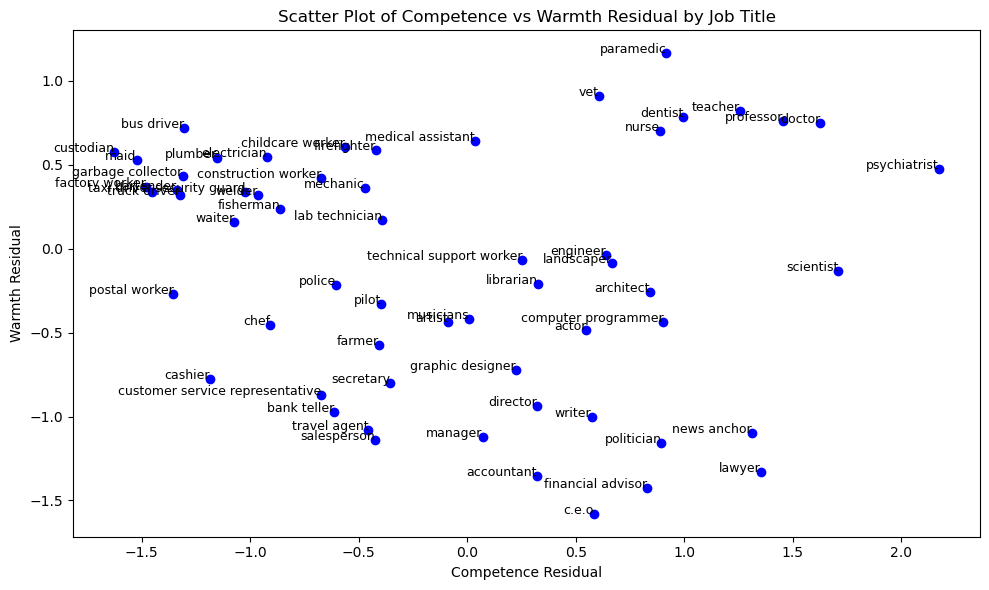

slope (Dir. of bias): -0.11093055344266989
intercept: -0.1254516579766225


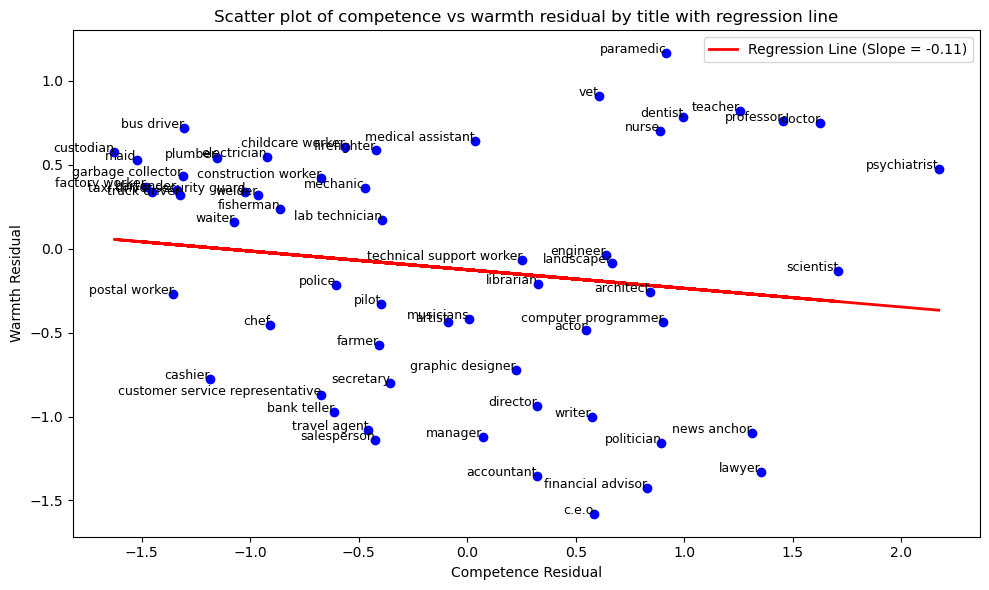

In [1326]:
combined_df2 = pd.read_excel('/Users/aleksandragarbat/Desktop/Thesis/combined_grouped_titles_summary2.xlsx')

plt.figure(figsize=(10, 6))

plt.scatter(combined_df2['Competence_residual'], combined_df2['Warmth_residual'], color='blue')

for i, row in combined_df2.iterrows():
    plt.text(row['Competence_residual'], row['Warmth_residual'], row['Grouped_Title'], fontsize=9, ha='right')

plt.xlabel('Competence Residual')
plt.ylabel('Warmth Residual')
plt.title('Scatter Plot of Competence vs Warmth Residual by Job Title')

plt.tight_layout()
plt.show()


from sklearn.linear_model import LinearRegression
#i still use this df
#combined_df2 = pd.read_excel('/Users/aleksandragarbat/Desktop/Thesis/combined_grouped_titles_summary2.xlsx')
#indepe. variable (competence residual) and dep var. (warmth residual)
X = combined_df2['Competence_residual'].values.reshape(-1, 1)  # Independent variable (Competence Residual)
y = combined_df2['Warmth_residual'].values  # Dependent variable (Warmth Residual)

#fit lin. reg.
model = LinearRegression()
model.fit(X, y)

#I need a slope
slope = model.coef_[0]
intercept = model.intercept_

print(f"slope (Dir. of bias): {slope}")
print(f"intercept: {intercept}")

#scatter
plt.figure(figsize=(10, 6))
plt.scatter(combined_df2['Competence_residual'], combined_df2['Warmth_residual'], color='blue')

#plotting the reg. line
#predicted val. of y using my created model
y_pred = model.predict(X)
plt.plot(combined_df2['Competence_residual'], y_pred, color='red', linewidth=2, label=f"Regression Line (Slope = {slope:.2f})")

#labels to points
for i, row in combined_df2.iterrows():
    plt.text(row['Competence_residual'], row['Warmth_residual'], row['Grouped_Title'], fontsize=9, ha='right')

#plot labels+ title
plt.xlabel('Competence Residual')
plt.ylabel('Warmth Residual')
plt.title('Scatter plot of competence vs warmth residual by title with regression line')


plt.legend()

plt.tight_layout()
plt.show()

In [1328]:
#bert
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [1422]:
professions = [
    "bus driver",
    "scientist",
    "engineer",
    "bartender",
    "maid",
    "nurse",
    "teacher",
    "doctor",
    "paramedic",
    "garbage collector",
    "c.e.o",
    "lawyer",
    "waiter",
    "childcare worker",
    "factory worker",
    "cashier",
    "architect",
    "bank teller",
    "salesperson",
    "customer service representative",
    "manager",
    "police",
    "plumber",
    "mechanic",
    "electrician",
    "postal worker",
    "lab technician",
    "financial advisor",
    "writer",
    "vet",
    "dentist",
    "firefighter",
    "accountant",
    "librarian",
    "computer programmer",
    "graphic designer",
    "chef",
    "welder",
    "security guard",
    "travel agent",
    "actor",
    "artist",
    "construction worker",
    "custodian",
    "director",
    "farmer",
    "fisherman",
    "landscaper",
    "medical assistant",
    "musician",
    "news anchor",
    "pilot",
    "politician",
    "professor",
    "secretary",
    "taxi driver",
    "technical support worker",
    "truck driver",
    "psychiatrist"
]
#lower/higher case doesnt matter

In [1424]:
def get_bert_embeddings(text):
    #encode the text with tokenizer
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    #pass the model to get the embeddings and i do not calc. grad.
    with torch.no_grad():
        outputs = model(**inputs)
    
    #geting the embed. from the last hidden state (last layers should have a fuller semantic meaning)
    embeddings = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)
    
    #takes mean of the embeddings across the sequence dimension
    #aim: get general representation and not rely on single token 
    sentence_embedding = embeddings.mean(dim=1).squeeze()
    
    return sentence_embedding
#extract embed. for professions
professions_embeddings = [get_bert_embeddings(profession) for profession in professions]

#print embed.
for profession, embedding in zip(professions, professions_embeddings):
    print(f"Embedding for {profession}: {embedding[:5]}...")

import pandas as pd

#create df to check the profession-embedding association
df_professions = pd.DataFrame({
    'Profession': professions,  # List of professions
    'Embedding': [embedding.numpy() for embedding in professions_embeddings]  # Original embeddings
})

print(df_professions.head())

print(df_professions)

Embedding for bus driver: tensor([ 0.4953, -0.3912, -0.3872, -0.0586, -0.1787])...
Embedding for scientist: tensor([-0.0932, -0.2024, -0.1676,  0.0241,  0.0625])...
Embedding for engineer: tensor([-0.0763,  0.1893, -0.3333,  0.1452,  0.0600])...
Embedding for bartender: tensor([ 0.3517,  0.0715, -0.1923,  0.0375, -0.0914])...
Embedding for maid: tensor([-0.0521, -0.0638, -0.0767, -0.2056, -0.1000])...
Embedding for nurse: tensor([ 0.1196,  0.0981, -0.1434,  0.0243, -0.1688])...
Embedding for teacher: tensor([ 0.1680, -0.0498, -0.0834,  0.0172, -0.2115])...
Embedding for doctor: tensor([ 0.1003,  0.2832,  0.0155,  0.1372, -0.0317])...
Embedding for paramedic: tensor([-0.1462, -0.6562, -0.1720, -0.0171,  0.3277])...
Embedding for garbage collector: tensor([ 0.4609, -0.1273, -0.0089,  0.3659,  0.1303])...
Embedding for c.e.o: tensor([-0.2657, -0.2996, -0.1914,  0.0548,  0.5368])...
Embedding for lawyer: tensor([ 0.1135, -0.0579, -0.2495, -0.0391,  0.0878])...
Embedding for waiter: tensor(

In [1426]:
#for pca embeddings needs to be standardized (I did not do pca in the end)
#embeddings for all jobs
#BERT embeddings for all jobs (professions)
professions_embeddings = [get_bert_embeddings(profession) for profession in professions]

#;ist to np array (row => profession embedding)
embeddings_array = np.array([embedding.numpy() for embedding in professions_embeddings])

#separate the professions from the embeddings for safe scaling
professions_column = professions  # Keep the profession names separate

#standardize embeddings (mean = 0, std. dev. = 1)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_array)

#create a df with the standardized embeddings
embeddings_df = pd.DataFrame(embeddings_scaled, columns=[f"Feature_{i+1}" for i in range(embeddings_scaled.shape[1])])

#add the profession column back at beginning of df
embeddings_df['Profession'] = professions_column

#to keep the profession column at the start
embeddings_df = embeddings_df[['Profession'] + [col for col in embeddings_df.columns if col != 'Profession']]

print(embeddings_df.head())



   Profession  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0  bus driver   1.668746  -1.460888  -0.668037  -0.771825  -1.482422   
1   scientist  -0.839787  -0.590218   0.491899  -0.127878  -0.178291   
2    engineer  -0.767643   1.217173  -0.383216   0.813843  -0.192088   
3   bartender   1.056590   0.673283   0.361732  -0.024089  -1.010408   
4        maid  -0.664496   0.049310   0.972315  -1.914884  -1.057135   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_759  Feature_760  \
0   0.223950  -0.792751   0.787731   0.561854  ...    -0.230035     0.055733   
1  -0.828405  -0.911669  -0.592209  -0.217698  ...    -0.206162     2.249811   
2  -1.073470   0.968368  -0.724078   0.484841  ...     1.569128     0.236300   
3  -1.218788  -1.104494   0.132494   0.221200  ...    -1.057354    -0.447635   
4  -0.718503   1.158732  -2.116665   1.336687  ...     0.587210     0.294233   

   Feature_761  Feature_762  Feature_763  Feature_764  Feature_765  \
0    -0.304727  

In [1432]:
#human judgement study results for comparison and validation of directions
import pandas as pd

path = "/Users/aleksandragarbat/Desktop/occupations_data.csv"
study_df = pd.read_csv(path)

#extract and rename the relevant columns
study_df = study_df[['Occupation', 'Mean1', 'Mean2']].copy()
study_df.rename(columns={
    'Occupation' : 'Grouped_Title',
    'Mean1': 'Warmth_Study',
    'Mean2': 'Competence_Study'
}, inplace=True)

#drop unavailable occupations from the study (occupation data study with SCM)
study_df = study_df[~study_df['Grouped_Title'].isin(['Military', 'Principal', 'Unemployed'])]

print(study_df.head())

print("Number of rows in study_df:", len(study_df))

#lowercase 'Grouped_Title' values
study_df['Grouped_Title'] = study_df['Grouped_Title'].str.lower()

#cleaned titles
print(study_df['Grouped_Title'].to_list())

#################################################################


  Grouped_Title  Warmth_Study  Competence_Study
0    Accountant          1.02             -0.55
1         Actor          0.06             -0.54
2     Architect          0.76              0.15
3        Artist         -0.35             -0.02
4   Bank teller         -0.17              0.38
Number of rows in study_df: 58
['accountant', 'actor', 'architect', 'artist', 'bank teller', 'bartender', 'bus driver', 'cashier', 'c.e.o.', 'chef', 'childcare worker', 'computer programmer', 'construction worker', 'custodian', 'customer service representative', 'dentist', 'director', 'doctor', 'electrician', 'engineer', 'factory worker', 'farmer', 'financial advisor', 'firefighter', 'fisherman', 'garbage collector', 'graphic designer', 'lab technician', 'landscaper', 'lawyer', 'librarian', 'maid', 'manager', 'mechanic', 'medical assistant', 'musician', 'news anchor', 'nurse', 'paramedic', 'pilot', 'plumber', 'police', 'politician', 'postal worker', 'professor', 'psychiatrist', 'salesperson', 'scientist

In [1434]:
print("df_scores:")
df_scores['Grouped_Title'] = df_scores['Grouped_Title'].str.lower()
print(df_scores.head())
print("df_embeddings:")
print(df_embeddings.head())
print("df_merged:")
print(df_merged.head())

df_scores:
  Grouped_Title  Warmth_residual  Competence_residual
0    bus driver         0.717730            -1.303917
1     scientist        -0.133292             1.710346
2      engineer        -0.038510             0.640317
3     bartender         0.349728            -1.339197
4          maid         0.528958            -1.524035
df_embeddings:


AttributeError: 'numpy.ndarray' object has no attribute 'head'

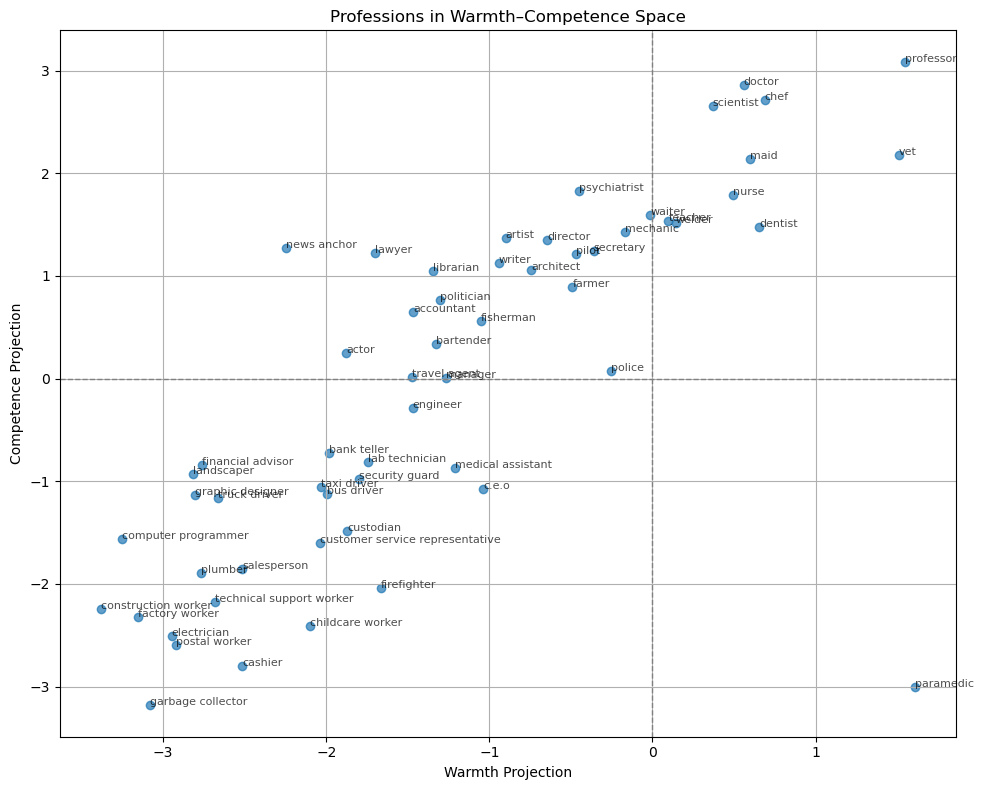

                  Grouped_Title  Cosine_Warmth  Cosine_Competence
                      professor       0.177139           0.352446
                            vet       0.175559           0.253191
                      paramedic       0.141324          -0.263213
                           chef       0.079725           0.314158
                        dentist       0.071707           0.162169
                           maid       0.067980           0.243225
                         doctor       0.065014           0.332662
                          nurse       0.057599           0.208410
                      scientist       0.042982           0.309793
                         welder       0.018293           0.192672
                        teacher       0.011523           0.182321
                         waiter      -0.001769           0.186898
                       mechanic      -0.019659           0.166009
                         police      -0.027134           0.007516
          

/var/folders/j8/zf_4c85j5plbmvlpz_x018h40000gn/T/ipykernel_37174/464265048.py:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


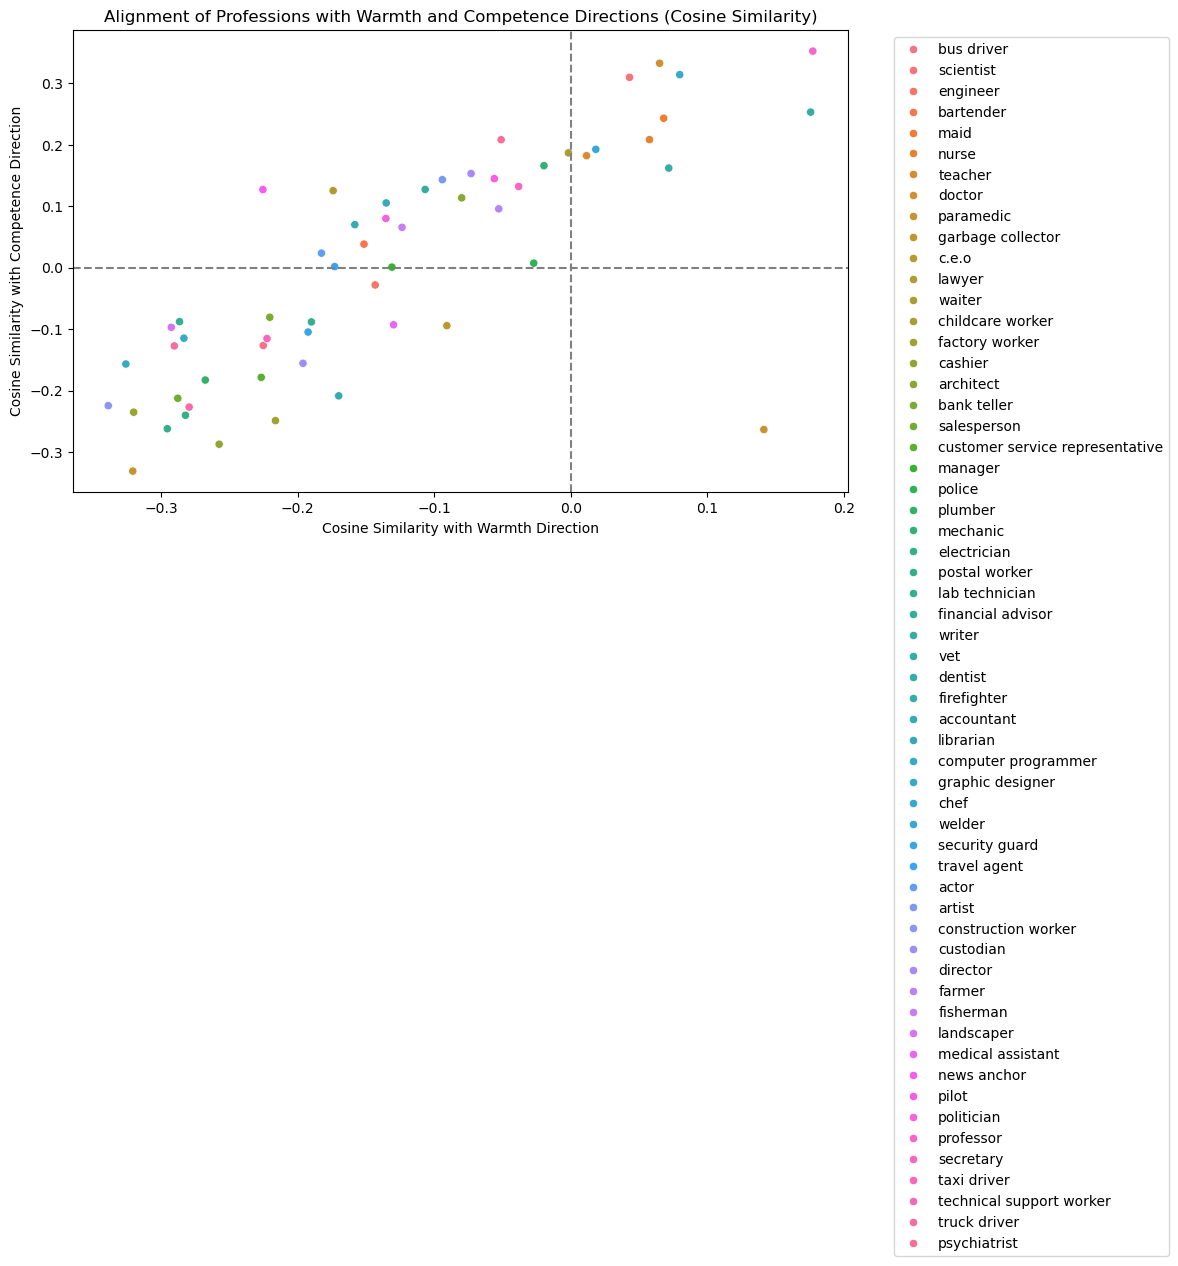

                  Grouped_Title  Cosine_Warmth  Cosine_Competence
                      professor       0.177139           0.352446
                            vet       0.175559           0.253191
                      paramedic       0.141324          -0.263213
                           chef       0.079725           0.314158
                        dentist       0.071707           0.162169
                           maid       0.067980           0.243225
                         doctor       0.065014           0.332662
                          nurse       0.057599           0.208410
                      scientist       0.042982           0.309793
                         welder       0.018293           0.192672
                        teacher       0.011523           0.182321
                         waiter      -0.001769           0.186898
                       mechanic      -0.019659           0.166009
                         police      -0.027134           0.007516
          

/var/folders/j8/zf_4c85j5plbmvlpz_x018h40000gn/T/ipykernel_37174/464265048.py:144: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


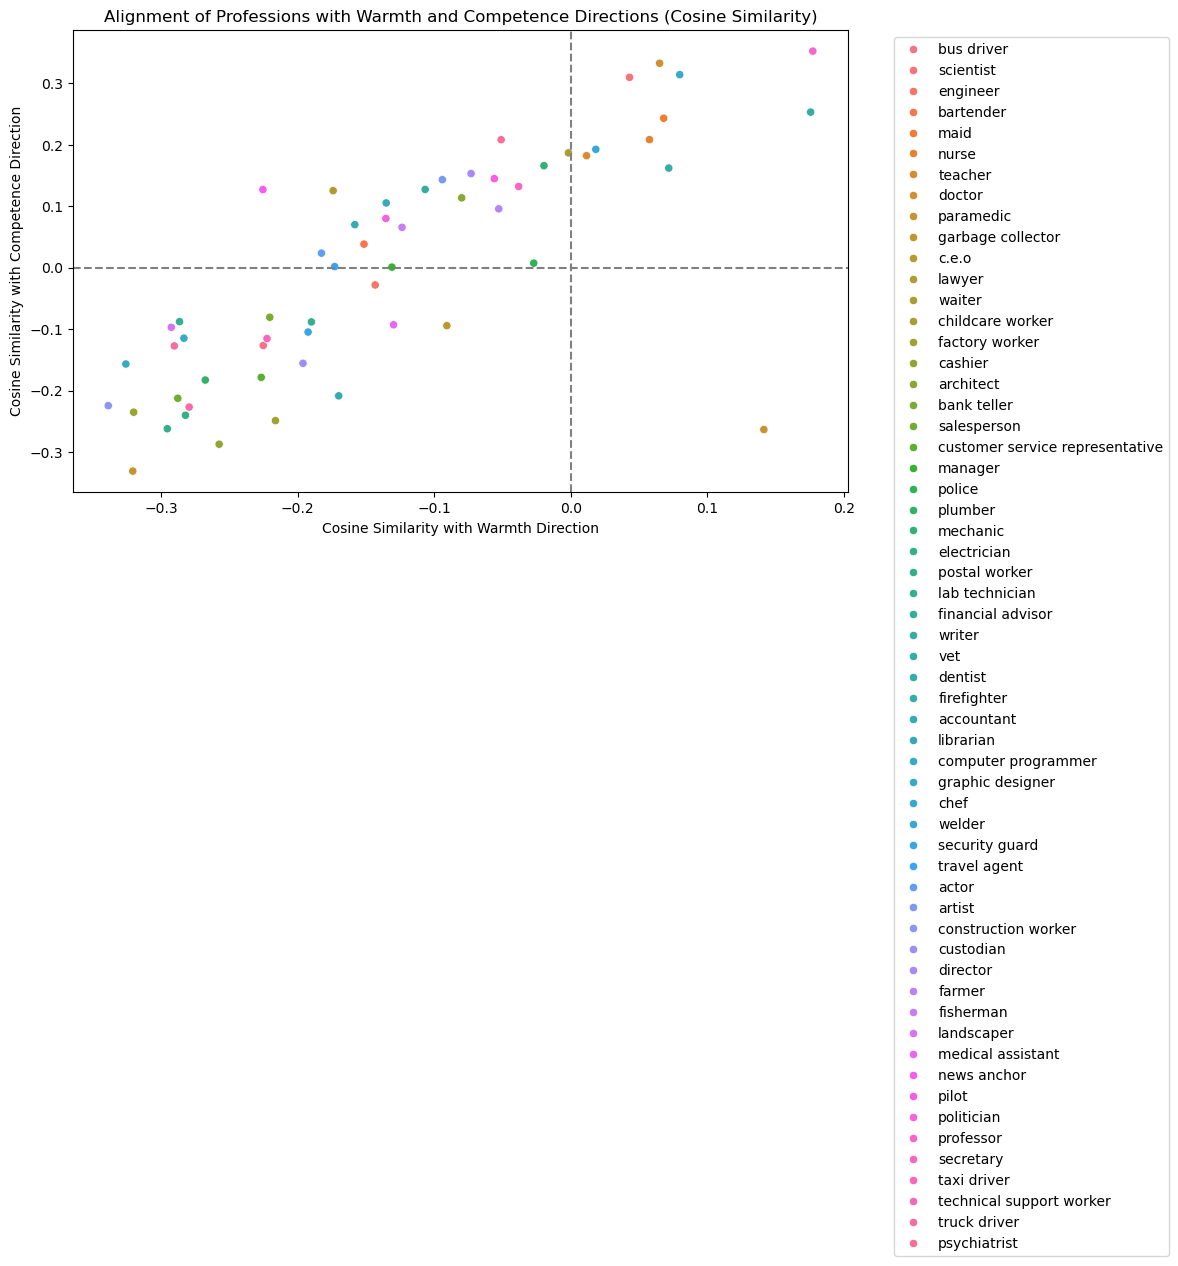

Pearson correlation (Warmth): 0.242, p-value: 0.0719
Pearson correlation (Competence): 0.198, p-value: 0.1440
Spearman correlation (Warmth): 0.281, p-value: 0.0358
Spearman correlation (Competence): 0.301, p-value: 0.0240


In [1520]:
#dynamic scaling (BIAS DIRECTIONS)
#the studu on SCM and occupations was focusing on sd so I applied splits based on sd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

#load warmth/competence scores
df_scores = pd.read_csv('/Users/aleksandragarbat/Desktop/Thesis/warmth_competence_scores.csv')
df_scores['Grouped_Title'] = df_scores['Grouped_Title'].str.lower()
# Ensure alignment on titles
df_embeddings = df_professions.rename(columns={'Profession': 'Grouped_Title'})

#merge embeddings with warmth/competence residuals
df_merged = df_embeddings.merge(df_scores, on='Grouped_Title')

#extract embeddings and residuals
embeddings = np.vstack(df_merged['Embedding'].values)  # shape: (n_professions, dim)
warmth_residuals = df_merged['Warmth_residual'].values
competence_residuals = df_merged['Competence_residual'].values

#apply dynamic range split (Z-scores for warmth and competence residuals)
warmth_zscore = zscore(warmth_residuals)
competence_zscore = zscore(competence_residuals)

#z-score threshold for split (threshold at +-1 or +-2 Z-scores of sd)
warm_embeddings = embeddings[warmth_zscore > 1.2]   # warm if z-score > 1
cold_embeddings = embeddings[warmth_zscore <= 1.2]  # cold if z-score <= 1
competent_embeddings = embeddings[competence_zscore > 1.2]  # competent if z-score > 1
incompetent_embeddings = embeddings[competence_zscore <= 1.2]  # incompetent if z-score <= 1

#compute centroids
warm_centroid = warm_embeddings.mean(axis=0)
cold_centroid = cold_embeddings.mean(axis=0)
competent_centroid = competent_embeddings.mean(axis=0)
incompetent_centroid = incompetent_embeddings.mean(axis=0)

#calculate bias directions
warmth_direction = warm_centroid - cold_centroid
competence_direction = competent_centroid - incompetent_centroid

#normalize direction vectors
warmth_direction /= np.linalg.norm(warmth_direction)
competence_direction /= np.linalg.norm(competence_direction)

#project embeddings onto the new warmth and competence directions
warmth_projection = embeddings @ warmth_direction
competence_projection = embeddings @ competence_direction

#add projections to df
df_merged['Warmth_proj'] = warmth_projection
df_merged['Competence_proj'] = competence_projection

#visualize
plt.figure(figsize=(10, 8))

#scatter
plt.scatter(df_merged['Warmth_proj'], df_merged['Competence_proj'], alpha=0.7)

#annotate professions
for i, row in df_merged.iterrows():
    plt.text(row['Warmth_proj'], row['Competence_proj'], row['Grouped_Title'],
             fontsize=8, alpha=0.7)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Professions in Warmth–Competence Space')
plt.xlabel('Warmth Projection')
plt.ylabel('Competence Projection')
plt.grid(True)
plt.tight_layout()
plt.show()

#cosine Similarity with respect to derived bias directions
embedding_matrix = np.vstack(df_merged['Embedding'].values)

#cosine similarity to each direction vector
df_merged['Cosine_Warmth'] = cosine_similarity(embedding_matrix, warmth_direction.reshape(1, -1)).flatten()
df_merged['Cosine_Competence'] = cosine_similarity(embedding_matrix, competence_direction.reshape(1, -1)).flatten()

#relevant columns
alignment_df = df_merged[['Grouped_Title', 'Cosine_Warmth', 'Cosine_Competence']]

#sorting
alignment_df_sorted = alignment_df.sort_values(by='Cosine_Warmth', ascending=False)

# Print the table
print(alignment_df_sorted.to_string(index=False))

#plotting the sosine similarity vs profession alignment
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Cosine_Warmth', 
    y='Cosine_Competence', 
    data=df_merged, 
    hue='Grouped_Title'
)
plt.axhline(0, linestyle='--', color='grey')
plt.axvline(0, linestyle='--', color='grey')
plt.title("Alignment of Professions with Warmth and Competence Directions (Cosine Similarity)")
plt.xlabel("Cosine Similarity with Warmth Direction")
plt.ylabel("Cosine Similarity with Competence Direction")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

######VALIDATE
embedding_matrix = np.vstack(df_merged['Embedding'].values)

#compute cosine similarity to each direction vector
df_merged['Cosine_Warmth'] = cosine_similarity(embedding_matrix, warmth_direction.reshape(1, -1)).flatten()
df_merged['Cosine_Competence'] = cosine_similarity(embedding_matrix, competence_direction.reshape(1, -1)).flatten()

alignment_df = df_merged[['Grouped_Title', 'Cosine_Warmth', 'Cosine_Competence']]

alignment_df_sorted = alignment_df.sort_values(by='Cosine_Warmth', ascending=False)

#table
print(alignment_df_sorted.to_string(index=False))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Cosine_Warmth', 
    y='Cosine_Competence', 
    data=df_merged, 
    hue='Grouped_Title'
)
plt.axhline(0, linestyle='--', color='grey')
plt.axvline(0, linestyle='--', color='grey')
plt.title("Alignment of Professions with Warmth and Competence Directions (Cosine Similarity)")
plt.xlabel("Cosine Similarity with Warmth Direction")
plt.ylabel("Cosine Similarity with Competence Direction")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

###VALIDATION
from scipy.stats import pearsonr, spearmanr

#merges cosine similarities with human study scores
merged_eval = df_merged[['Grouped_Title', 'Cosine_Warmth', 'Cosine_Competence']].merge(study_df, on='Grouped_Title', how='inner')

#pearson correlations and p-values
warmth_corr, warmth_p = pearsonr(merged_eval['Cosine_Warmth'], merged_eval['Warmth_Study'])
competence_corr, competence_p = pearsonr(merged_eval['Cosine_Competence'], merged_eval['Competence_Study'])

#compute Spearman correlations and p-values (more appropriate!!!!!!!!)
spearman_warmth, spearman_p_warmth = spearmanr(merged_eval['Cosine_Warmth'], merged_eval['Warmth_Study'])
spearman_competence, spearman_p_competence = spearmanr(merged_eval['Cosine_Competence'], merged_eval['Competence_Study'])

#results
print(f"Pearson correlation (Warmth): {warmth_corr:.3f}, p-value: {warmth_p:.4f}")
print(f"Pearson correlation (Competence): {competence_corr:.3f}, p-value: {competence_p:.4f}")

print(f"Spearman correlation (Warmth): {spearman_warmth:.3f}, p-value: {spearman_p_warmth:.4f}")
print(f"Spearman correlation (Competence): {spearman_competence:.3f}, p-value: {spearman_p_competence:.4f}")

###divided the professions based on how extreme their warmth and competence residuals are (measured in terms of standard deviations from the mean)

####both spearman warmth and competence significant

####FINAL..................... 
import pandas as pd

#vectors to df (each vector as a single row)
warmth_df = pd.DataFrame([warmth_direction])
competence_df = pd.DataFrame([competence_direction])

#save toscv files (no row index)
warmth_df.to_csv('warmth_direction.csv', index=False)
competence_df.to_csv('competence_direction.csv', index=False)

warmth_df.to_csv('/Users/aleksandragarbat/Desktop/Thesis/warmth_direction.csv', index=False)
competence_df.to_csv('/Users/aleksandragarbat/Desktop/Thesis/competence_direction.csv', index=False)
